# Machine Learning Project Serie 1: 
# IMDB movie review sentiment classification

# Episode 1: Shallow neural networks

Welcome to my personal machine learning project serie!

This machine learning project will explore the IMDB movie review sentiment classification dataset and try out a few different machine learning approaches to find out which perform the best on such problem. This episode will focus on training and testing shallow neural netowrk models with 3 simple neural networks.

# I. Importing Tensorflow and other necessary libraries

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras as K
import time
import csv

Instructions for updating:
non-resource variables are not supported in the long term


# II. Extracting data: IMDB movie review sentiment classification dataset

This is a dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a list of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

Reference: https://keras.io/api/datasets/imdb/#imdb-movie-review-sentiment-classification-dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data()

17465344/17464789 [==============================] - 0s 0us/step


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do t

# III. Investigating datasets
### 1. Labels on training and testing sets:

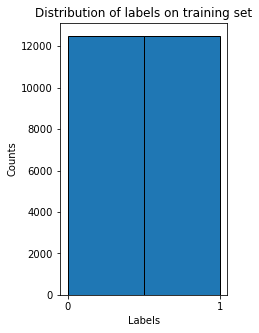

The distribution of training set is not skewed. Positivities take up: 50.0%



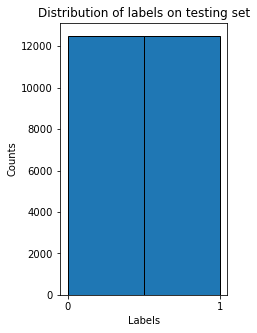

The distribution of testing set is not skewed. Positivities take up: 50.0%



In [4]:
# ----------TRAINING SET----------
# Plot the labels on a histogram 
fig, ax = plt.subplots(figsize=(3, 5))
ax.hist(y_train, bins=2, ec='k')
ax.locator_params(axis='x', integer=True)
plt.title("Distribution of labels on training set")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.show()

# The number of positive comments / The number of comments (training)
percent_positives_train = np.sum(y_train)/y_train.shape[0]
if percent_positives_train < 0.2:
    print("The distribution of training set is skewed. Positivities take up:", str(percent_positives_train * 100) + "%\n")
else:
    print("The distribution of training set is not skewed. Positivities take up:", str(percent_positives_train * 100) + "%\n")


# ----------TESTING SET----------
# Plot the labels on a histogram 
fig, ax = plt.subplots(figsize=(3, 5))
ax.hist(y_train, bins=2, ec='k')
ax.locator_params(axis='x', integer=True)
plt.title("Distribution of labels on testing set")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.show()
    
# The number of positive comments / The number of comments (test)
percent_positives_test = np.sum(y_test)/y_test.shape[0]
if percent_positives_test < 0.2:
    print("The distribution of testing set is skewed. Positivities take up:", str(percent_positives_test * 100) + "%\n")
else:
    print("The distribution of testing set is not skewed. Positivities take up:", str(percent_positives_test * 100) + "%\n")
    

### Conclusion
Hence, general accuracy (nof correct predictions / nof predictions) can be used to reflect the performance of the machine.

### 2. Word dictionary structure

In [5]:
word_dict = tf.keras.datasets.imdb.get_word_index(path="imdb_word_index.json")

1646592/1641221 [==============================] - 0s 0us/step


In [6]:
word_dict = dict(sorted(word_dict.items(), key=lambda item: item[1]))

In [7]:
word_list = list(word_dict)
word_list.insert(0, str(0)) # To make the index of each word matches it position in original dictionary

In [8]:
print("Total words count:", len(word_list))

Total words count: 88585


# IV. Data preprocessing
### 1. Choosing features:
The features will be in binary form encoding the appearance of certain words in a comment. 1 means the word did appear in the comment and 0 means the opposite. The order of features will be from the most used words to least used ones. Since 88584 words are too many to run on my laptop, I'll use only the n most used words in the comments to be the new features.

In [9]:
max_features = 300  # Choose maximum n most used words
required_len = 4    # But exclude the words that does not match required length

def choose_word_index():
    chosen_indexes = []
    i = 0
    while len(chosen_indexes) < max_features:
        if len(word_list[i]) >= required_len:
            chosen_indexes.append(i)
        i += 1
    return chosen_indexes

In [10]:
accounted_word_indexes = choose_word_index()
nof_features = len(accounted_word_indexes)
print("Number of words picked: " + str(nof_features))

Number of words picked: 300


### 2. Splitting original sets to train/validation/test sets:
Original test set will be kept the way it is. Only original training set is split into train/validation sets

Training set size : 25000
Testing set shape : 25000



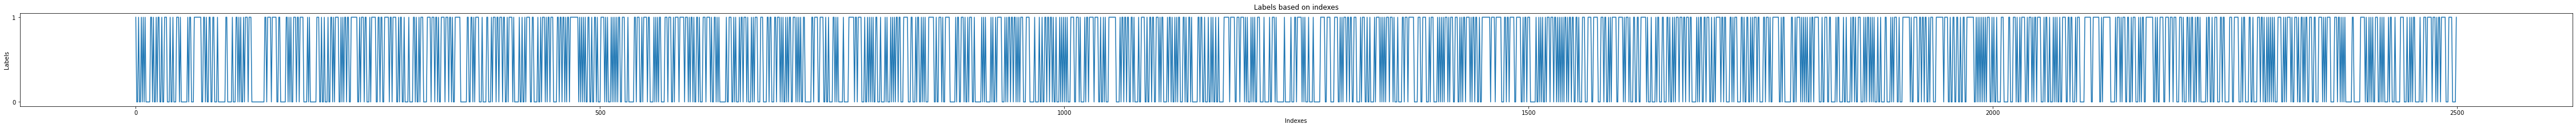

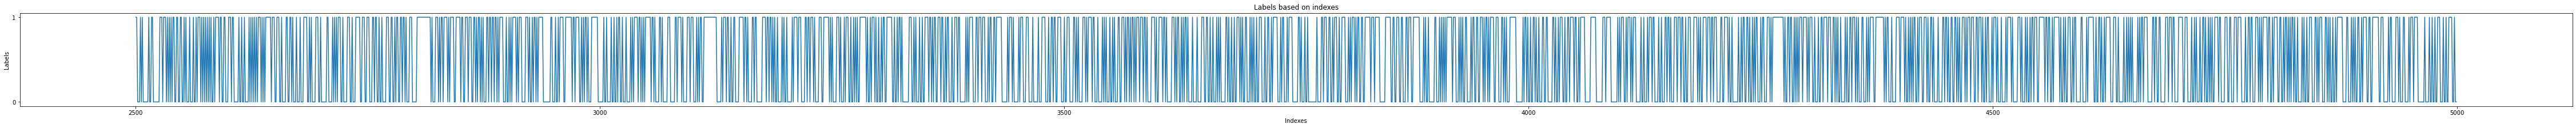

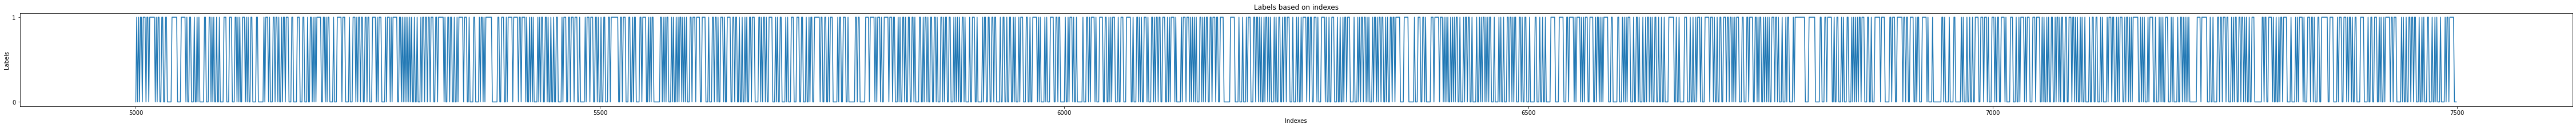

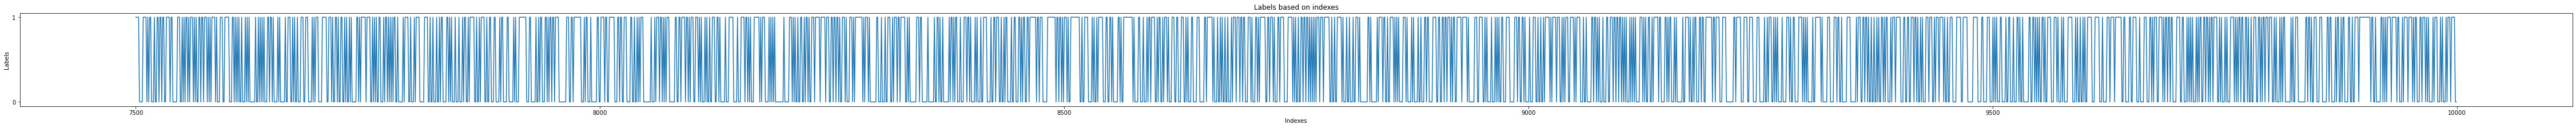

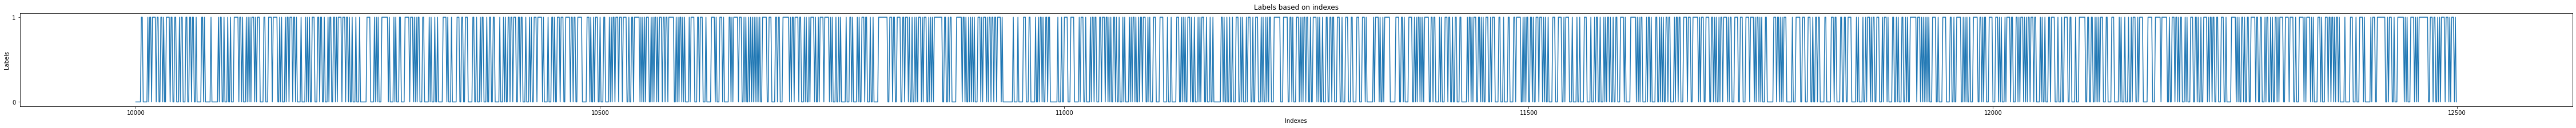

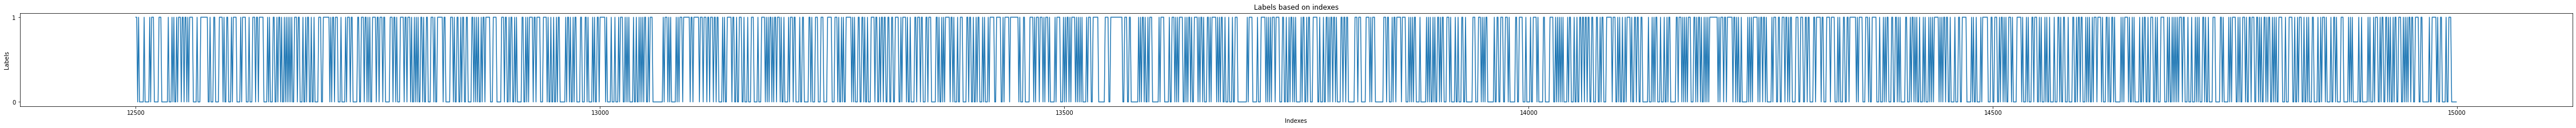

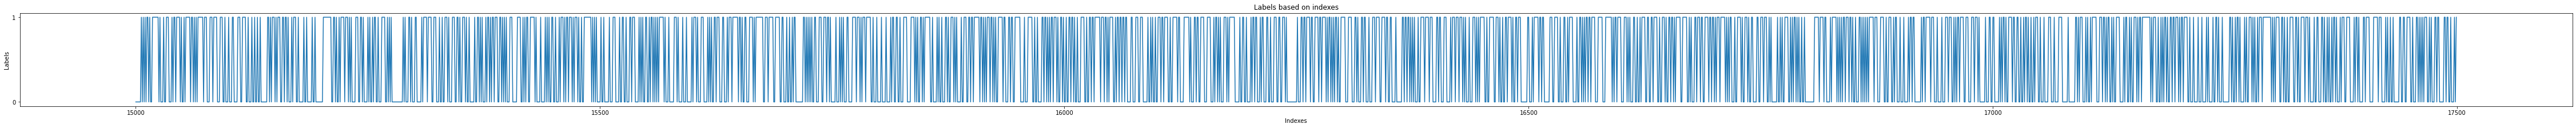

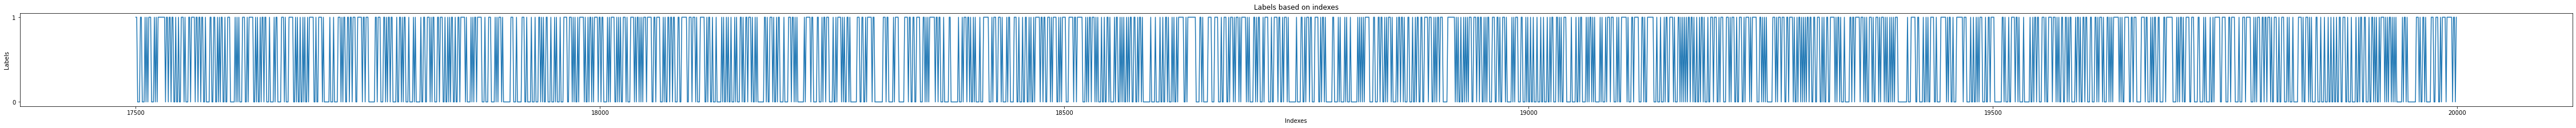

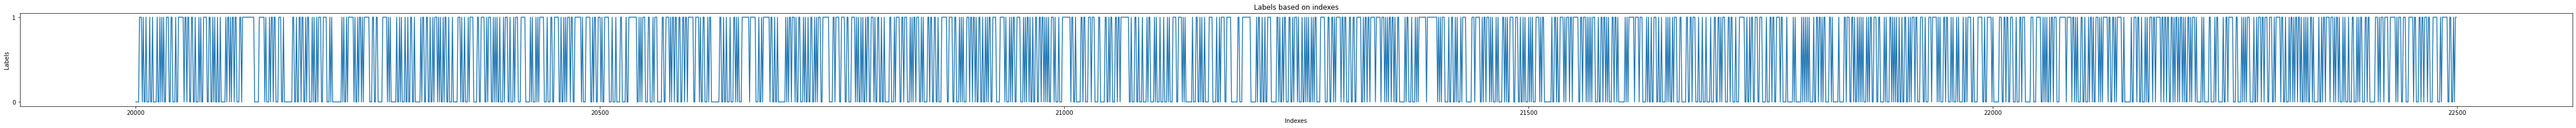


New training set size  : 20000
New validation set size: 5000
New testing set size   : 25000


In [11]:
initial_train_len = x_train.shape[0]
print("Training set size : " + str(initial_train_len))

initial_test_len = x_test.shape[0]
print("Testing set shape : " + str(initial_test_len) + '\n')

subset_size = 2500
for i in range(int(25000/subset_size-1)):
    fig, ax = plt.subplots(figsize=(80, 3))
    plt.plot(range(i*subset_size, (i+1)*subset_size), y_train[(i*subset_size) : ((i+1)*subset_size)])
    ax.locator_params(axis='x', integer=True)
    ax.locator_params(axis='y', integer=True)
    plt.title("Labels based on indexes")
    plt.xlabel("Indexes")
    plt.ylabel("Labels")
    plt.show()

# Split original data sets to train/validation/test sets:
validation_len = 5000

train_set      = (x_train[0 : initial_train_len - validation_len], y_train[0 : initial_train_len - validation_len])
new_train_len  = len(train_set[0])
print("\nNew training set size  :", new_train_len)

validation_set = (x_train[initial_train_len - validation_len : ],  y_train[initial_train_len - validation_len : ])
new_validation_len = len(validation_set[0])
print("New validation set size:", new_validation_len)

test_set       = (x_test, y_test)
new_test_len = len(test_set[0])
print("New testing set size   :", new_test_len)

### Conclusion
The line charts of labels according to indexes above show that the training data has been shuffled as garuanteed when loaded. Hence, splitting the dataset with only one cursor as above should give unbiased train/validation sets. 

### 3. Recostructing input data:
Turning original input data of shape (nof_examples, *undefined*) to (nof_features, nof_examples) 

In [12]:
def construct_input(initial_input):
    new_input = []
    for word_index in accounted_word_indexes:
        if word_index in initial_input:
            new_input.append(1)
        else:
            new_input.append(0)
    return new_input

In [13]:
# Initialize new train/validation/test sets
new_x_train      = np.zeros((new_train_len,      nof_features))
new_y_train      = np.zeros((new_train_len,      1))

new_x_validation = np.zeros((new_validation_len, nof_features))
new_y_validation = np.zeros((new_validation_len, 1))

new_x_test       = np.zeros((new_test_len,       nof_features))
new_y_test       = np.zeros((new_test_len,       1))

# Reconstruct the train/validation/test sets to the aforementioned format:

# TRAINING SET:
for example_index in range(new_train_len):
    new_x_train[example_index]      = construct_input(train_set[0][example_index])
    new_y_train[example_index]      =                 train_set[1][example_index]

# VALIDATION SET
for example_index in range(new_validation_len):
    new_x_validation[example_index] = construct_input(validation_set[0][example_index])
    new_y_validation[example_index] =                 validation_set[1][example_index]

# TEST SET
for example_index in range(new_test_len):
    new_x_test[example_index]       = construct_input(test_set[0][example_index])
    new_y_test[example_index]       =                 test_set[1][example_index]
    
# Transposing the sets for simpler usage later on
new_x_train      = new_x_train.T
new_y_train      = new_y_train.T

new_x_validation = new_x_validation.T
new_y_validation = new_y_validation.T

new_x_test       = new_x_test.T
new_y_test       = new_y_test.T

In [13]:
print("One example of training input is  :\n" + str(new_x_train[:, 1000]) + "\nWith label: " + str(new_y_train[:, 1000]) + '\n')
    
print("One example of validation input is:\n" + str(new_x_validation[:, 1000]) + "\nWith label: " + str(new_y_validation[:, 1000]) + '\n')
    
print("One example of test input is      :\n" + str(new_x_test[:, 10000]) + "\nWith label: " + str(new_y_test[:, 10000]) + '\n')

One example of training input is  :
[1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
With label: [0.]

One example of validation input 

# V. Machine Learning Models
3 different neural network models will be trained on training set and validated on validation set to decide which model will be used to test with the test set. The models are:
- Neural network with 0 hidden layer, without regularization
- Neural network with 2 hidden layer, without regularization
- Neural network with 3 hidden layer, without regularization

### 1. Model One: 
Neural network with 0 hidden layer, without regularization
 - Final layer will have Sigmoid activation

In [14]:
# Initialize parameters for model One:
def initialize_params_m1():
    # Weights and Biases:
    W1 = tf.get_variable('W1_m1', [1 ,nof_features], initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=20))
    b1 = tf.get_variable('b1_m1', [1,1], initializer = tf.zeros_initializer())
    parameters = {'W1': W1, 'b1': b1}
    return parameters

In [15]:
# Forward propagation for model One:
def forward_m1(X, parameters):
    # Extract parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    
    # Forward propagation
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.sigmoid(Z1)
    return A1

### 2. Model Two: 
Neural network with 2 hidden layers, without regularization
 - Hidden layer 1 has (nof_features/3*2) units (Leaky ReLu activation)
 - Hidden layer 2 has (nof_features/3*1) units (Leaky ReLu activation)
 - Final layer will have Sigmoid activation

In [16]:
# Initialize parameters for model Two:
def initialize_params_m2():
    hl1_units = int(nof_features/3*2)
    hl2_units = int(nof_features/3*1)
    # Weights and Biases:
    W1 = tf.get_variable('W1_m2', [hl1_units, nof_features], initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=20))
    b1 = tf.get_variable('b1_m2', [hl1_units, 1], initializer = tf.zeros_initializer())
    
    W2 = tf.get_variable('W2_m2', [hl2_units, hl1_units], initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=30))
    b2 = tf.get_variable('b2_m2', [hl2_units, 1], initializer = tf.zeros_initializer())
    
    W3 = tf.get_variable('W3_m2', [1, hl2_units], initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=40))
    b3 = tf.get_variable('b3_m2', [1, 1], initializer = tf.zeros_initializer())
    parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    return parameters

In [17]:
# Forward propagation for model Two:
def forward_m2(X, parameters):
    # Extract parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Forward propagation
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.leaky_relu(Z1)
    
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.leaky_relu(Z2)
    
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    A3 = tf.sigmoid(Z3)
    
    return A3

### 3. Model Three:
Neural network with 2 hidden layer, with regularization
- Hidden layer 1 has (nof_features/3*2) units (Leaky ReLu activation)
- Hidden layer 2 has (nof_features/3*1) units (Leaky ReLu activation)
- Hidden layer 3 has (nof_features/5) units (Leaky ReLu activation)
- Final layer will have Sigmoid activation

In [18]:
# Initialize parameters for model Three:
def initialize_params_m3():
    hl1_units = int(nof_features/3*2)
    hl2_units = int(nof_features/3*1)
    hl3_units = int(nof_features/5)
    # Weights and Biases:
    W1 = tf.get_variable('W1_m3', [hl1_units, nof_features], initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=20))
    b1 = tf.get_variable('b1_m3', [hl1_units, 1], initializer = tf.zeros_initializer())
    
    W2 = tf.get_variable('W2_m3', [hl2_units, hl1_units], initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=30))
    b2 = tf.get_variable('b2_m3', [hl2_units, 1], initializer = tf.zeros_initializer())
    
    W3 = tf.get_variable('W3_m3', [hl3_units, hl2_units], initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=40))
    b3 = tf.get_variable('b3_m3', [hl3_units, 1], initializer = tf.zeros_initializer())
    
    W4 = tf.get_variable('W4_m3', [1, hl3_units], initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=50))
    b4 = tf.get_variable('b4_m3', [1, 1], initializer = tf.zeros_initializer())
    parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3, 'W4': W4, 'b4': b4}
    return parameters

In [19]:
# Forward propagation for model Three:
def forward_m3(X, parameters):
    # Extract parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    
    # Forward propagation
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.leaky_relu(Z1)
    
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.leaky_relu(Z2)
    
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    A3 = tf.nn.leaky_relu(Z3)
    
    Z4 = tf.add(tf.matmul(W4, A3), b4)
    A4 = tf.sigmoid(Z4)
    
    return A4

### Modeling and Training

In [20]:
# Make prediction based on final activation units for model One:
def predict(A):
    prediction = tf.cast(tf.greater_equal(A, 0.5), 'float') # Choose threshold at 0.5
    return prediction

In [21]:
def model_nn(X_train_input, Y_train_input, model_name='m1', learning_rate=0.05, epochs=2000, print_loss_interval=10):
    
    tf.reset_default_graph()
    
    # Creating neural network model input:
    X = tf.placeholder(tf.float32, [nof_features, None], name='X') # The inputs
    Y = tf.placeholder(tf.float32, [1, None], name='Y')            # The labels
    
    # Initializing parameters of the neural network and output final activation units
    parameters = {}
    if model_name == 'm1':
        parameters = initialize_params_m1()
        A = forward_m1(X, parameters)
    elif model_name == 'm2':
        parameters = initialize_params_m2()
        A = forward_m2(X, parameters)
    elif model_name == 'm3':
        parameters = initialize_params_m3()
        A = forward_m3(X, parameters)
    
    # Predict sentimental classification unit based on 'A'
    prediction = predict(A)
    
    # Loss function and optimizing method
    Loss = tf.reduce_mean(tf.square(tf.subtract(A, Y)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(Loss)

    # List to store the lost values after some interations for later visualization
    loss_values = [] 
    iterations  = range(1, epochs+1)

    # Start training
    init = tf.global_variables_initializer()
    start_time = time.time()
    
    with tf.Session() as sess:
        sess.run(init)
        
        # Run gradient descent for 'epochs' times
        for epoch in range(1, epochs+1):    
            _, loss = sess.run(fetches=[optimizer, Loss], feed_dict={X:new_x_train, Y:new_y_train})
            loss_values.append(loss)
            
            # Print this as a reference
            if epoch == 1 or epoch % (epochs/print_loss_interval) == 0:
                print("Training loss after", epoch, "iterations:", loss)
              
        # Plot learning curve
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.plot(iterations, loss_values)
        plt.title("Learning curve")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

        # Save parameters for accuracy test on training and validation sets
        parameters = sess.run(parameters)
        
        # Training time
        print("The model took approximately", round((time.time() - start_time)/60), "minutes to train\n")
        
        # Accuracy:
        correct_prediction = tf.equal(prediction, Y)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print("Train Accuracy     :", accuracy.eval({X: X_train_input,    Y: Y_train_input}))
        print("Validation Accuracy:", accuracy.eval({X: new_x_validation, Y: new_y_validation}))
        print("Validation Loss    :", Loss.eval({X: new_x_validation, Y: new_y_validation}))
        
        return parameters

# VI. Training and Validating ML Models 

### 1. Model One: 

Read saved parameters out of csv files so the model does not have to be retrained everytime.

In [22]:
params_m1 = {}
# Read values if this is NOT the first time the machine is run
params_m1['W1'] = np.loadtxt(open('m1/l1/m1_w1.csv', 'r'), delimiter=',').astype(np.float32).reshape(1, nof_features)
params_m1['b1'] = np.loadtxt(open('m1/l1/m1_b1.csv', 'r'), delimiter=',').astype(np.float32).reshape(1, 1)

Training loss after 1 iterations: 0.25172582
Training loss after 200 iterations: 0.20845781
Training loss after 400 iterations: 0.1886126
Training loss after 600 iterations: 0.17753081
Training loss after 800 iterations: 0.17039257
Training loss after 1000 iterations: 0.16536082
Training loss after 1200 iterations: 0.16159587
Training loss after 1400 iterations: 0.15865794
Training loss after 1600 iterations: 0.15629321
Training loss after 1800 iterations: 0.1543441
Training loss after 2000 iterations: 0.15270707


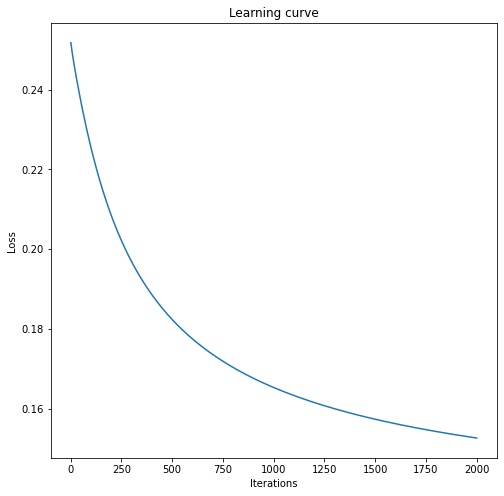

The model took approximately 2 minutes to train

Train Accuracy     : 0.79255
Validation Accuracy: 0.792
Validation Loss    : 0.15459378


In [77]:
params_m1 = model_nn(new_x_train, new_y_train, model_name='m1', learning_rate=0.05, epochs=2000, print_loss_interval=10)
# Store parameters in csv files for later use:
np.savetxt('m1/l1/m1_w1.csv', params_m1['W1'], delimiter=',')
np.savetxt('m1/l1/m1_b1.csv', params_m1['b1'], delimiter=',')

### 2. Model Two:

Read saved parameters out of csv files so the model does not have to be retrained everytime.

In [23]:
params_m2 = {}
m2_hl1_units = int(nof_features/3*2)
m2_hl2_units = int(nof_features/3*1)
# Read values if this is NOT the first time the machine is run
params_m2['W1'] = np.loadtxt(open('m2/l1/m2_w1.csv', 'r'), delimiter=',').astype(np.float32).reshape(m2_hl1_units, nof_features)
params_m2['b1'] = np.loadtxt(open('m2/l1/m2_b1.csv', 'r'), delimiter=',').astype(np.float32).reshape(m2_hl1_units, 1)

params_m2['W2'] = np.loadtxt(open('m2/l2/m2_w2.csv', 'r'), delimiter=',').astype(np.float32).reshape(m2_hl2_units, m2_hl1_units)
params_m2['b2'] = np.loadtxt(open('m2/l2/m2_b2.csv', 'r'), delimiter=',').astype(np.float32).reshape(m2_hl2_units, 1)

params_m2['W3'] = np.loadtxt(open('m2/l3/m2_w3.csv', 'r'), delimiter=',').astype(np.float32).reshape(1, m2_hl2_units)
params_m2['b3'] = np.loadtxt(open('m2/l3/m2_b3.csv', 'r'), delimiter=',').astype(np.float32).reshape(1, 1)

Training loss after 1 iterations: 0.24827202
Training loss after 200 iterations: 0.2417336
Training loss after 400 iterations: 0.22493911
Training loss after 600 iterations: 0.19246295
Training loss after 800 iterations: 0.16796692
Training loss after 1000 iterations: 0.15485984
Training loss after 1200 iterations: 0.14725153
Training loss after 1400 iterations: 0.14260375
Training loss after 1600 iterations: 0.13968366
Training loss after 1800 iterations: 0.13778798
Training loss after 2000 iterations: 0.13649987


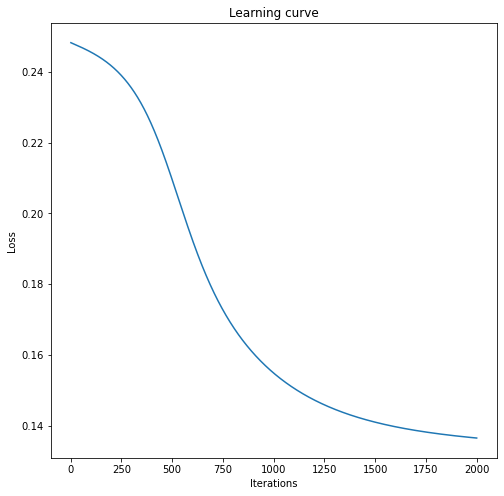

The model took approximately 9 minutes to train

Train Accuracy     : 0.8089
Validation Accuracy: 0.7974
Validation Loss    : 0.14307016


In [78]:
params_m2 = model_nn(new_x_train, new_y_train, model_name='m2', learning_rate=0.05, epochs=2000, print_loss_interval=10)
# Store parameters in csv files for later use:
np.savetxt('m2/l1/m2_w1.csv', params_m2['W1'], delimiter=',')
np.savetxt('m2/l1/m2_b1.csv', params_m2['b1'], delimiter=',')

np.savetxt('m2/l2/m2_w2.csv', params_m2['W2'], delimiter=',')
np.savetxt('m2/l2/m2_b2.csv', params_m2['b2'], delimiter=',')

np.savetxt('m2/l3/m2_w3.csv', params_m2['W3'], delimiter=',')
np.savetxt('m2/l3/m2_b3.csv', params_m2['b3'], delimiter=',')

### 3. Model Three:

Read saved parameters out of csv files so the model does not have to be retrained everytime.

In [24]:
params_m3 = {}
m3_hl1_units = int(nof_features/3*2)
m3_hl2_units = int(nof_features/3*1)
m3_hl3_units = int(nof_features/5)
# Read values if this is NOT the first time the machine is run
params_m3['W1'] = np.loadtxt(open('m3/l1/m3_w1.csv', 'r'), delimiter=',').astype(np.float32).reshape(m3_hl1_units, nof_features)
params_m3['b1'] = np.loadtxt(open('m3/l1/m3_b1.csv', 'r'), delimiter=',').astype(np.float32).reshape(m3_hl1_units, 1)

params_m3['W2'] = np.loadtxt(open('m3/l2/m3_w2.csv', 'r'), delimiter=',').astype(np.float32).reshape(m3_hl2_units, m3_hl1_units)
params_m3['b2'] = np.loadtxt(open('m3/l2/m3_b2.csv', 'r'), delimiter=',').astype(np.float32).reshape(m3_hl2_units, 1)

params_m3['W3'] = np.loadtxt(open('m3/l3/m3_w3.csv', 'r'), delimiter=',').astype(np.float32).reshape(m3_hl3_units, m3_hl2_units)
params_m3['b3'] = np.loadtxt(open('m3/l3/m3_b3.csv', 'r'), delimiter=',').astype(np.float32).reshape(m3_hl3_units, 1)

params_m3['W4'] = np.loadtxt(open('m3/l4/m3_w4.csv', 'r'), delimiter=',').astype(np.float32).reshape(1, m3_hl3_units)
params_m3['b4'] = np.loadtxt(open('m3/l4/m3_b4.csv', 'r'), delimiter=',').astype(np.float32).reshape(1, 1)

Training loss after 1 iterations: 0.2498148
Training loss after 200 iterations: 0.24945381
Training loss after 400 iterations: 0.24888912
Training loss after 600 iterations: 0.24781589
Training loss after 800 iterations: 0.24542798
Training loss after 1000 iterations: 0.23883569
Training loss after 1200 iterations: 0.2172309
Training loss after 1400 iterations: 0.17894903
Training loss after 1600 iterations: 0.15767439
Training loss after 1800 iterations: 0.1471549
Training loss after 2000 iterations: 0.14143562


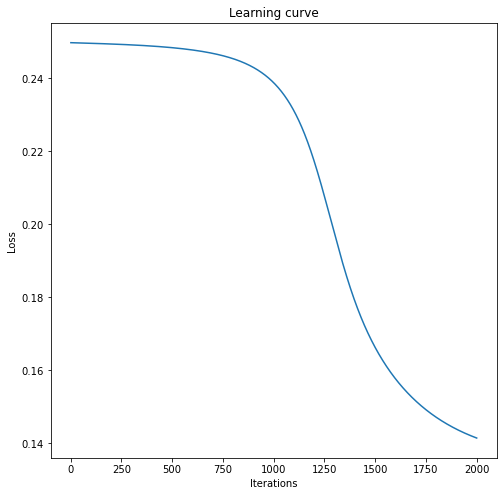

The model took approximately 10 minutes to train

Train Accuracy     : 0.7992
Validation Accuracy: 0.7914
Validation Loss    : 0.14586183


In [79]:
params_m3 = model_nn(new_x_train, new_y_train, model_name='m3', learning_rate=0.05, epochs=2000, print_loss_interval=10)
# Store parameters in csv files for later use:
np.savetxt('m3/l1/m3_w1.csv', params_m3['W1'], delimiter=',')
np.savetxt('m3/l1/m3_b1.csv', params_m3['b1'], delimiter=',')

np.savetxt('m3/l2/m3_w2.csv', params_m3['W2'], delimiter=',')
np.savetxt('m3/l2/m3_b2.csv', params_m3['b2'], delimiter=',')

np.savetxt('m3/l3/m3_w3.csv', params_m3['W3'], delimiter=',')
np.savetxt('m3/l3/m3_b3.csv', params_m3['b3'], delimiter=',')

np.savetxt('m3/l4/m3_w4.csv', params_m3['W4'], delimiter=',')
np.savetxt('m3/l4/m3_b4.csv', params_m3['b4'], delimiter=',')

### Conclusion:

Compare result in table:

| |Model One|Model Two|Model Three|
|-|-|-|-|
|# Hidden layers    |0      |2      |3      |
|Training accuracy  |79.255%|80.890%|79.920%|
|Validation accuracy|79.200%|79.740%|79.140%|
|Training loss      |0.15271|0.13650|0.14144|
|Validation loss    |0.15459|0.14307|0.14586|

From the table, Model Two has the highest training and validation accuracy, as well as lowest training and validation loss. Undoubtedly, Model Three currently demonstrates the best performance. Hence, it will be chosen to test on the test set. 

Before moving on to the next part, I just want to check if the models simply predict the same output for every datapoint, will the new results approximate the above results.

In [96]:
print("Approximately", int(np.mean(new_y_train)*100), "% of the training set are positive examples.")
print("Approximately", int(np.mean(new_y_validation)*100), "% of the validation set are positive examples.")

Approximately 50 % of the training set are positive examples.
Approximately 49 % of the validation set are positive examples.


So if the models predict the same output everytime, it will yield only 50% accuracy. The above results are still better.

# VII. Evaluation on testing set

Primarily evaluating Model Two on the test set, but I will also take a peek at how Model One and Model Three perform on the test set. 

In [26]:
def evaluate(X_test, Y_test, model_name='m1', print_values=True):
    
    tf.reset_default_graph()
    
    # Creating neural network model input:
    X = tf.placeholder(tf.float32, [nof_features, None], name='X') # The inputs
    Y = tf.placeholder(tf.float32, [1, None], name='Y')            # The labels
    
    # Initializing parameters of the neural network and output final activation units
    if model_name == 'm1':
        A = forward_m1(X, params_m1)
    elif model_name == 'm2':
        A = forward_m2(X, params_m2)
    elif model_name == 'm3':
        A = forward_m3(X, params_m3)
        
    # Loss function
    Loss = tf.reduce_mean(tf.square(tf.subtract(A, Y)))
    
    # Predict sentimental classification unit based on 'A'
    prediction = predict(A)
    
    # Accuracy
    correct_prediction = tf.equal(prediction, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        
    # Start evaluating
    loss_value, test_accuracy = None, None
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        loss_value, test_accuracy = sess.run(fetches=[Loss, accuracy], feed_dict={X:X_test, Y:Y_test})
        if print_values:
            print("Loss value:", loss_value)
            print("Testing accuracy:", test_accuracy)
        
    return loss_value, test_accuracy

In [27]:
evaluate(new_x_test, new_y_test, model_name='m1')

Loss value: 0.15667918
Testing accuracy: 0.7826


(0.15667918, 0.7826)

In [28]:
evaluate(new_x_test, new_y_test, model_name='m2')

Loss value: 0.14500156
Testing accuracy: 0.79248


(0.14500156, 0.79248)

In [29]:
evaluate(new_x_test, new_y_test, model_name='m3')

Loss value: 0.14862546
Testing accuracy: 0.78672


(0.14862546, 0.78672)

### Conclusion

||Model One|Model Two|Model Three|
|-|-|-|-|
|Testing accuracy|78.260%|79.248%|78.672%|
|Testing loss    |0.15668|0.14500|0.14863|

The validation works, Model Two performed the most significant on the test set. However, 79.248% is still low. The next part will informally investigate further to see what is likely the problems of the model.

# VIII. Problems Analysis

Creating and training a model is sure challenging, but for me, the hardest part is inspecting and analysing the weaknesses of the model and deciding what to do better next time.

### 1. True Poitive, True Negative, False Positive, False Negative

In [54]:
def test_set_analyse(X_test, Y_test, model_name='m1'):
    
    tf.reset_default_graph()
    
    # Creating neural network model input:
    X = tf.placeholder(tf.float32, [nof_features, None], name='X') # The inputs
    Y = tf.placeholder(tf.float32, [1, None], name='Y')            # The labels
    
    # Initializing parameters of the neural network and output final activation units
    if model_name == 'm1':
        A = forward_m1(X, params_m1)
    elif model_name == 'm2':
        A = forward_m2(X, params_m2)
    elif model_name == 'm3':
        A = forward_m3(X, params_m3)
        
    # Predict sentimental classification unit based on 'A'
    prediction = predict(A)
    
    # Inspecting all 4 components: True Positive, True Negative, False Positive, False Negative (over test set)
    TP = tf.reduce_mean(prediction           * Y)
    TN = tf.reduce_mean(tf.abs(prediction-1) * tf.abs(Y-1))
    FP = tf.reduce_mean(prediction           * tf.abs(Y-1))
    FN = tf.reduce_mean(tf.abs(prediction-1) * Y)
    
    # Start evaluating
    init_g = tf.global_variables_initializer()
    init_l = tf.local_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init_g)
        sess.run(init_l)
        predictions, tp, tn, fp, fn = sess.run(fetches=[prediction, TP, TN, FP, FN], feed_dict={X:X_test, Y:Y_test})
        
        print("Approximately", int(np.mean(predictions)*100), "% of predictions are positive outputs.\n")
        
        print("True Positive portion   :", tp)
        print("True Negative portion   :", tn, '\n')
        
        print("False Positive portion  :", fp)
        print("False Negative portion  :", fn, '\n')
        
        print("True prediction portion :", tp + tn)
        print("False prediction portion:", fp + fn)
        print("Total                   :", tp + tn + fp + fn)
    return

In [55]:
test_set_analyse(new_x_test, new_y_test)

Approximately 51 % of predictions are positive outputs.

True Positive portion   : 0.39692
True Negative portion   : 0.38568 

False Positive portion  : 0.11432
False Negative portion  : 0.10308 

True prediction portion : 0.7826
False prediction portion: 0.2174
Total                   : 0.99999994


### $Conclusion:$

The model seems to perform equally well on both negative and positive datapoints, and it also return equal amounts of negative and positive predictions.

### 2. Model performance over comment length

Testing whether model performance gets better on longer comments. To implement this, I will divide test set into many smaller datasets, each new dataset will contain only datapoints that represent comments with the number of detected words fall in a specific range. For example: dataset_1 contains comments with 0 to 10 words; dataset_2 contains comments with 10 to 20 words; and so on dataset_n contains comments with 10(n-1) to 10n words. The final dataset might not have the same range as others. I will then measure accuracy on each of those new datasets to see if there is any correlation.

In [148]:
# The maximum number of chosen words detected in a comment
max_comment_len = int(np.max(np.sum(new_x_test, axis=0))) 
print("Maximum number of of chosen words detected in a comment:", max_comment_len)

# Number of words range in each dataset
words_range = 10

# Set of new smaller datasets
divided_test_sets = []

# Loop through all intervals
for interval in range(int(max_comment_len/words_range)):
    input_set = []
    output_set = []
    
    # Loop through all test datapoints to pick the ones satisfy the range
    for test_index in range(new_test_len):
        if np.sum(new_x_test.T[test_index]) in range(interval * words_range, (interval+1) * words_range):
            input_set .append(new_x_test.T[test_index])
            output_set.append(new_y_test.T[test_index])
    
    divided_test_sets.append((np.array(input_set).T, np.array(output_set).T))
    
# Loop though all other comments not inside intervals
inputs = []
outputs = []
for test_index in range(new_test_len):
    if np.sum(new_x_test.T[test_index]) in range(int(max_comment_len/words_range) * words_range, max_comment_len+1):
        inputs .append(new_x_test.T[test_index])
        outputs.append(new_y_test.T[test_index])
        
divided_test_sets.append((np.array(inputs).T, np.array(outputs).T))

Maximum number of of chosen words detected in a comment: 166


In [149]:
# Construct x_labels values for the plots (list of min words in each dataset)
max_words_list = np.array(range(0, max_comment_len, words_range))
print("List of min words in each dataset:", max_words_list)

List of min words in each dataset: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160]


In [150]:
print("Total number of new sets:", len(divided_test_sets))

dataset_index = 10 # Any number between 0 to len(divided_test_sets)
print(str(dataset_index) + "th input  dataset has the shape of:", np.array(divided_test_sets[dataset_index][0]).shape)
print(str(dataset_index) + "th output dataset has the shape of:", np.array(divided_test_sets[dataset_index][1]).shape)

Total number of new sets: 17
10th input  dataset has the shape of: (300, 288)
10th output dataset has the shape of: (1, 288)


In [151]:
test_losses     = []
test_accuracies = []

for divided_set in divided_test_sets:
    l, a = evaluate(divided_set[0], divided_set[1], model_name='m2', print_values=False)
    test_losses.append(l)
    test_accuracies.append(a)

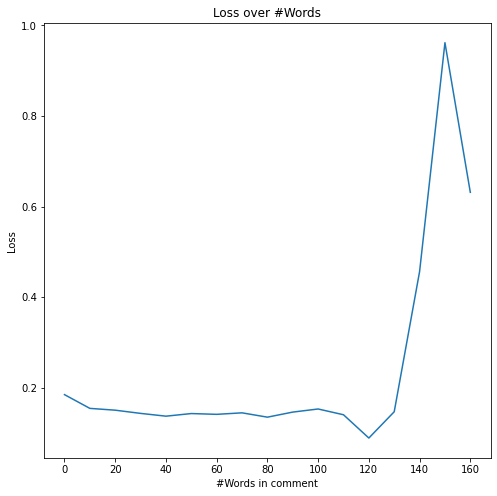

In [152]:
# Plot curve of loss over #words in comment
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(max_words_list, test_losses)
plt.title("Loss over #Words")
plt.xlabel("#Words in comment")
plt.ylabel("Loss")
plt.show()

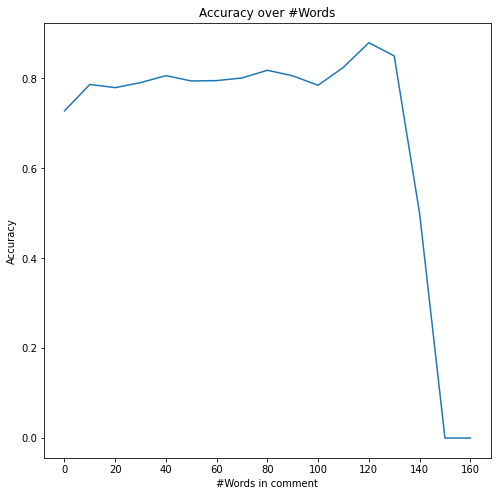

In [153]:
# Plot curve of accuracy over #words in comment
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(max_words_list, test_accuracies)
plt.title("Accuracy over #Words")
plt.xlabel("#Words in comment")
plt.ylabel("Accuracy")
plt.show()

### $Conclusion$

The graphs indicate that though there are fluctuations, the overall performance of Model Two indeed improves when the number of detected words increases. However, when the number of detected words get too large (above 120), the opposite happens. 

There are certainly many other problems with the model, but this is getting too long. Therefore, I will look deeper and find more problems of the model to improve in the next episodes.

# IX. Thank you

Thank you for reading Episode 1 of my project serie. I hope it didn't bore you. See you on the next episode!